###Install required libraries for finetuning a model in HuggingFace

In [ ]:
!pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git
!pip install -q -U datasets bitsandbytes einops wandb

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-vcwysu96/unsloth_87ab6b4b95bb4c2db5b9fc439c2b4fb9
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-vcwysu96/unsloth_87ab6b4b95bb4c2db5b9fc439c2b4fb9
  Resolved https://github.com/unslothai/unsloth.git to commit a7bfbe7927ea75f959e1d7c84e7bf50945d405ff
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


###Load the base model "Llama-3 8b" in quantized form for efficient memory usage

In [ ]:
# Load the model

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoTokenizer

model_name = "unsloth/llama-3-8b-bnb-4bit"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    trust_remote_code=True
)
model.config.use_cache = False

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
/usr/local/lib/python3.10/dist-packages/transformers/quantizers/auto.py:174: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)
`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

In [ ]:
# Load the tokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

###Load the three datasets from HuggingFace to fine-tune the LLAMA3 model

In [ ]:
from datasets import load_dataset, Dataset
import pandas as pd

Dataset 1 - "CodeExercise-Python-27k" \\
**NOTE:** We were not able to directly load this dataset from HuggingFace, thus we cloned it and manipulated the JSON file to extract the necessary information

In [ ]:
# Clone the dataset

!git clone https://huggingface.co/datasets/codefuse-ai/CodeExercise-Python-27k

fatal: destination path 'CodeExercise-Python-27k' already exists and is not an empty directory.


In [ ]:
%cd CodeExercise-Python-27k
!ls

/content/CodeExercise-Python-27k
approach-en.png  CodeExercise-Python-27k.json  LOGO.png			 README.md
approach.png	 LICENSE		       preprocessed_dataset.csv


In [ ]:
# Read the JSON lines contained in the dataset and store in a list "data"

import json

data = []

with open('CodeExercise-Python-27k.json') as f:
    for line in f:
        try:
            # Parse each line as a JSON object and append to the list
            data.append(json.loads(line.strip()))
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
            continue

In [ ]:
# Display the different key-value pairs in the JSON lines to extract the proper information

print(data[0])

{'data_name': 'CodeExercise-Py', 'id': 0, 'chat_rounds': [{'role': 'human', 'content': 'Write a Python function named "add_numbers" that takes two parameters, "num1" and "num2", and returns the sum of the two numbers.\nInput: None', 'chat_round_id': 0}, {'role': 'bot', 'content': '```python\ndef add_numbers(num1, num2):\n    """\n    This function takes two numbers as input and returns their sum.\n\n    Parameters:\n    num1 (int or float): The first number.\n    num2 (int or float): The second number.\n\n    Returns:\n    int or float: The sum of num1 and num2.\n    """\n    return num1 + num2\n\n# Example usage\nresult = add_numbers(5, 3)\nprint(result)  # Output: 8\n\n\n```', 'chat_round_id': 1}]}


In [ ]:
# Extract the features 'human' and 'bot' from the JSON files and store them in lists "prompts" and "respnses" respectively
# then save the stored information into a csv file as a DataFrame

import pandas as pd

# Initialize lists to hold the prompts and responses
prompts = []
responses = []

# Iterate through the list of data
for item in data:
    # Extract the 'human' and 'bot' content
    human_content = None
    bot_content = None
    for round in item['chat_rounds']:
        if round['role'] == 'human':
            human_content = round['content']
        elif round['role'] == 'bot':
            bot_content = round['content']

    # Append to the lists
    prompts.append(human_content)
    responses.append(bot_content)

# Create a DataFrame with two columns: 'prompt' and 'response'
df = pd.DataFrame({
    'prompt': prompts,
    'response': responses
})

# Display the DataFrame
print(df.head())

# Optionally, save the DataFrame to a CSV file
df.to_csv('preprocessed_dataset.csv', index=False)

                                              prompt  \
0  Write a Python function named "add_numbers" th...   
1  Write a Python function named "multiply_number...   
2  Write a Python function named "power_of" that ...   
3  Write a Python function named "is_even" that t...   
4  Write a Python function named "is_prime" that ...   

                                            response  
0  ```python\ndef add_numbers(num1, num2):\n    "...  
1  ```python\ndef multiply_numbers(num1, num2):\n...  
2  ```python\ndef power_of(base, exponent):\n    ...  
3  ```python\ndef is_even(number):\n    """\n    ...  
4  ```python\ndef is_prime(number):\n    """\n   ...  


In [ ]:
# Read the csv file
dataset_1 = pd.read_csv('/content/CodeExercise-Python-27k/preprocessed_dataset.csv')

# Convert the DataFrame to a Hugging Face Dataset
dataset_1 = Dataset.from_pandas(dataset_1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset2 - "ibl-best-practices-instructor-dataset"

In [ ]:
# Load the dataset from HuggingFace

dataset_2 = load_dataset("iblai/ibl-best-practices-instructor-dataset", split="train")

Dataset 3 - "PythonTutor-Evol-1k-DPO-GPT4_vs_35"

In [ ]:
# Load the dataset from HuggingFace

dataset_3 = load_dataset("KrisPi/PythonTutor-Evol-1k-DPO-GPT4_vs_35", split="train")

###Data Pre-processing

In [ ]:
# Display the feature columns of the three datasets

print(dataset_1.column_names)
print(dataset_2.column_names)
print(dataset_3.column_names)

['prompt', 'response']
['virtue', 'prompt', 'response']
['instruction', 'output', 'gpt4_output']


In [ ]:
# Change the feature names 'instruction' to 'prompt' and 'output' to 'response' in Dataset 3
def preprocess_dataset(dataset, prompt_col, response_col):
    return dataset.rename_column(prompt_col, "prompt").rename_column(response_col, "response")

dataset_3 = preprocess_dataset(dataset_3, 'instruction', 'output')

In [ ]:
print(dataset_1.column_names)
print(dataset_2.column_names)
print(dataset_3.column_names)

['prompt', 'response']
['virtue', 'prompt', 'response']
['prompt', 'response', 'gpt4_output']


In [ ]:
# Concatenate the three datasets into one combined dataset

from datasets import concatenate_datasets
combined_dataset = concatenate_datasets([dataset_1, dataset_2, dataset_3])

In [ ]:
combined_dataset

Dataset({
    features: ['prompt', 'response', 'virtue', 'gpt4_output'],
    num_rows: 28547
})

In [ ]:
# Shuffle the combined dataset
shuffled_dataset = combined_dataset.shuffle(seed=42)

In [ ]:
shuffled_dataset

Dataset({
    features: ['prompt', 'response', 'virtue', 'gpt4_output'],
    num_rows: 28547
})

In [ ]:
# Remove columns that are not needed for training ('virtue' and 'gpt4_output')
shuffled_dataset = shuffled_dataset.remove_columns(["virtue", "gpt4_output"])
shuffled_dataset

Dataset({
    features: ['prompt', 'response'],
    num_rows: 28547
})

In [ ]:
# Format the shuffled dataset to one form that has its contect in the field "text"

prompt = """Below is an instruction that describes a question. Write a response that appropriately completes the request.

### prompt:
{}

### response:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    prompt = examples["prompt"]
    response = examples["response"]
    texts = []
    for prompt, response in zip(prompt, response):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = prompt.format(prompt, response) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass


shuffled_dataset = shuffled_dataset.map(formatting_prompts_func, batched = True,)

In [ ]:
shuffled_dataset

Dataset({
    features: ['prompt', 'response', 'text'],
    num_rows: 28547
})

In [ ]:
# Tokenize the shuffled dataset to prepare for training

def tokenize_function(examples):
    return tokenizer(examples["text"])

tokenized_dataset = shuffled_dataset.map(tokenize_function, batched=True)

In [ ]:
tokenized_dataset

Dataset({
    features: ['prompt', 'response', 'text', 'input_ids', 'attention_mask'],
    num_rows: 28547
})

In [ ]:
# Split the tokenized data into 80% for training and 20% for testing
train_test_split = tokenized_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

###Training and Evaluation

In [ ]:
# Configure the QLora adapters for efficient finetuning

from peft import LoraConfig, get_peft_model

lora_alpha = 16
lora_dropout = 0
lora_r = 64

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                       "gate_proj", "up_proj", "down_proj",]
)

# enabling gradient checkpointing before the PEFT model
model.enable_input_require_grads()

model = get_peft_model(model, peft_config)

In [ ]:
# Define the training arguments

from transformers import TrainingArguments

output_dir = "./results"
per_device_train_batch_size = 1
gradient_accumulation_steps = 8
optim = "adamw_8bit"
save_steps = 10
logging_steps = 10
learning_rate = 2e-4
max_grad_norm = 0.3
max_steps = 30
warmup_ratio = 0.03
lr_scheduler_type = "linear"


training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    fp16 = not torch.cuda.is_bf16_supported(),
    bf16 = torch.cuda.is_bf16_supported(),
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,
    gradient_checkpointing=True,
    warmup_steps = 5,
    weight_decay = 0.01,
    seed = 3407
)

In [ ]:
import torch

torch.cuda.empty_cache()

In [ ]:
# Define the metrics we need to evaluate the finetuned model on using the test data (precision, recall, F1-score, and accuracy)

def custom_metrics(eval_pred):
    metric1 = load_metric("precision")
    metric2 = load_metric("recall")
    metric3 = load_metric("f1")
    metric4 = load_metric("accuracy")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    precision = metric1.compute(predictions=predictions, references=labels, average="micro")["precision"]
    recall = metric2.compute(predictions=predictions, references=labels, average="micro")["recall"]
    f1 = metric3.compute(predictions=predictions, references=labels, average="micro")["f1"]
    accuracy = metric4.compute(predictions=predictions, references=labels)["accuracy"]

    return {"precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy}

In [ ]:
# Define the trainer

from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    compute_metrics=custom_metrics
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:280: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:318: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:408: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This migh

In [ ]:
# Run the training

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
10,0.590200
20,0.518100
30,0.471800


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


TrainOutput(global_step=30, training_loss=0.5267316977183024, metrics={'train_runtime': 3824.0046, 'train_samples_per_second': 0.063, 'train_steps_per_second': 0.008, 'total_flos': 6589204621565952.0, 'train_loss': 0.5267316977183024, 'epoch': 0.010509261286508736})

In [ ]:
trainer.state.log_history

[{'loss': 0.5902,
  'grad_norm': 0.20000144839286804,
  'learning_rate': 0.00016,
  'epoch': 0.003503087095502912,
  'step': 10},
 {'loss': 0.5181,
  'grad_norm': 0.13611510396003723,
  'learning_rate': 8e-05,
  'epoch': 0.007006174191005824,
  'step': 20},
 {'loss': 0.4718,
  'grad_norm': 0.13952688872814178,
  'learning_rate': 0.0,
  'epoch': 0.010509261286508736,
  'step': 30},
 {'train_runtime': 3824.0046,
  'train_samples_per_second': 0.063,
  'train_steps_per_second': 0.008,
  'total_flos': 6589204621565952.0,
  'train_loss': 0.5267316977183024,
  'epoch': 0.010509261286508736,
  'step': 30}]

In [ ]:
# Extract training loss from log_history
losses = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
steps = [log['step'] for log in trainer.state.log_history if 'loss' in log]

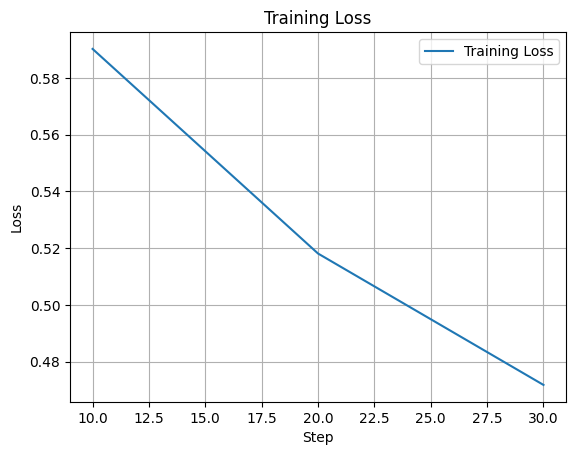

In [ ]:
# Plot the training loss

import matplotlib.pyplot as plt

# Plotting the training loss
plt.plot(steps, losses, label='Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Evaluate the fine-tuned model
results = trainer.evaluate()

# Print evaluation results
print(results)

# !!!!!!!! NOTE: We were not able to run the evaulation to compute the evaluation metrics due to GPU resources limitation

OutOfMemoryError: CUDA out of memory. Tried to allocate 274.00 MiB. GPU 

In [ ]:
# Evaluate the model on the test set

import evaluate

trainer.evaluate()

ValueError: Trainer: evaluation requires an eval_dataset.

In [ ]:
# Print the number of trainable parameters

trainable_params = 0
all_param = 0
for _, param in model.named_parameters():
  all_param += param.numel()
  if param.requires_grad:
    trainable_params += param.numel()
print(
    f"trainable params: {trainable_params} || all params: {all_param} || trainables%: {100 * trainable_params / all_param}"
)

trainable params: 167772160 || all params: 4708372480 || trainables%: 3.5632728870252848


###Save the finetuned model and tokenizer

In [ ]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Save the model

# Specify the path to save the model
save_directory = "/content/drive/MyDrive/MSBA 316 NLP/Project/our model"

# Save the tokenizer and the model
tokenizer.save_pretrained(save_directory)
model.save_pretrained(save_directory)